In [8]:
import scipy.io as scio
import logging
from functools import lru_cache
import scipy.stats as st
import numpy as np
import os
from tqdm.auto import tqdm, trange
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset,DataLoader,SubsetRandomSampler
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

import math
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [9]:
os.chdir('/Users/sheeta/Desktop/learn_torch/Task3')

In [4]:
#create mask for data reconstruction
diffdata = scio.loadmat('diff_abs.mat')
diff = torch.Tensor(diffdata['diff_abs'])
mask = torch.where(diff<0.01, torch.zeros_like(diff), torch.ones_like(diff))
mask = mask.squeeze()
an_array = np.array(mask)
repetitions = 1406

repeats_mask = np.tile(an_array, (repetitions, 1))
diff = diff.squeeze()

In [21]:
mask_list = []
for i in mask:
    mask_list.append(int(i))

In [28]:
mask_list

array([0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1,
       1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [29]:
scio.savemat('mask.mat',mask_list) 

AttributeError: 'numpy.ndarray' object has no attribute 'items'

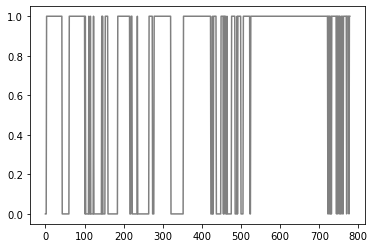

In [23]:
plt.plot(mask, c = 'grey')

In [4]:
diff.size()

torch.Size([779])

In [5]:
zerocount = 0
for i in mask:
    if i ==0:
        zerocount +=1
print(zerocount)


236


In [6]:
cancerdata= scio.loadmat('cancer')
cancer = torch.Tensor(cancerdata['cancerdata'])
# cancer = torch.transpose(cancer,0,1)

In [7]:
cancer.size()

torch.Size([1406, 779])

In [8]:
#damage spec
damaged_cancer = torch.where(diff<0.01, torch.zeros_like(cancer), cancer)
damaged_cancer = [damaged_cancer, repeats_mask]

In [11]:
training_data = np.load('training_data.npy',allow_pickle=True)
X1 = torch.Tensor([i[0] for i in training_data])
X2 = torch.Tensor([i[1] for i in training_data])
X = torch.stack((X1, X2), dim=1)
y = torch.Tensor([i[2] for i in training_data])

VAL_PCT = 0.1  # lets reserve 10% of our data for validation
val_size = int(len(X)*VAL_PCT)

train_X = X[:-val_size]
train_y = y[:-val_size]

test_X = X[-val_size:]
test_y = y[-val_size:]

In [12]:
dropout = 0.2
learning_rate = 1e-3
BATCH_SIZE = 32
# model_params = {'input_dim': input_dim,
#                 'hidden_dim' : hidden_dim,
#                 'layer_dim' : layer_dim,
#                 'output_dim' : output_dim,
#                 'dropout_prob' : dropout}
# net = get_model('lstm', model_params)


## Dataloader

In [13]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__() 
        torch.manual_seed(20010315)
        self.conv1 = nn.Conv1d(2, 32,5 ,dilation = 3 ,padding = 6)
        self.conv2 = nn.Conv1d(32, 64, 5,dilation = 3,padding = 6) 
        self.conv3 = nn.Conv1d(64, 128, 5,padding = 6)
        self.D = nn.Dropout(0.2)
      #  self.lstm = nn.LSTM(input_size=len(orig_npc[0]), hidden_size=256, num_layers=3)
        x = torch.randn(2*779).view(-1,2,779)
        self._to_linear = None
        self.convs(x)
        self.fc1 = nn.Linear(self._to_linear, 779) #flattening.
   
    def convs(self, x):
        x = F.max_pool1d(F.leaky_relu(self.conv1(x)), (2))
        x = F.max_pool1d(F.leaky_relu(self.conv2(x)), (2))
        x = F.max_pool1d(F.leaky_relu(self.conv3(x)), (2))

        if self._to_linear is None:
            self._to_linear = x[0].shape[0]*x[0].shape[1]
        return x
    

    def forward(self, x):
        x = self.convs(x)
        x = x.view(-1, self._to_linear)  # .view is reshape ... this flattens X before 
        x = self.D(x)
        x = self.fc1(x)
        return x
net = CNN()

/opt/anaconda3/lib/python3.8/site-packages/torch/nn/functional.py:652: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /Users/distiller/project/conda/conda-bld/pytorch_1623459044803/work/c10/core/TensorImpl.h:1156.)
  return torch.max_pool1d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [14]:
def fwd_pass(X,y,train = False):
    if train:
        net.zero_grad()
    
    output = net(X)
    loss = loss_function(output,y)
    output = output.detach().numpy()
    score  = [r2_score(i,j) for i, j in zip(output, y)]
    score = np.mean(score)
    if train:
        loss.backward()
        optimizer.step()
    return loss, score

In [17]:
optimizer = optim.Adam(net.parameters(), lr=learning_rate)
loss_function = nn.MSELoss()
def train(net = net,
          epochs=13,
          BATCH_SIZE = BATCH_SIZE):
    loss_train = []
    for e in trange(epochs):
        for i in tqdm(range(0, len(train_X), BATCH_SIZE)):
            batch_X = train_X[i:i+BATCH_SIZE].view(-1,2,779)
            batch_y = train_y[i:i+BATCH_SIZE].view(-1,1,779).squeeze(1)
            loss,score = fwd_pass(batch_X, batch_y, train=True)
            loss_train.append(loss)
        print('Train','loss:', loss, 'score:' ,score )
        loss_test, r2score_test = test(size = 100)
        print('Test','loss:', loss_test, 'score:' ,r2score_test )
        
train()

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Train loss: tensor(0.0021, grad_fn=<MseLossBackward>) score: 0.7792536482320096
Test loss: tensor(0.0689) score: -0.06695848120307696


  0%|          | 0/40 [00:00<?, ?it/s]

Train loss: tensor(0.0057, grad_fn=<MseLossBackward>) score: -0.523119245987655
Test loss: tensor(0.0920) score: -0.715182131578151


  0%|          | 0/40 [00:00<?, ?it/s]

Train loss: tensor(0.0017, grad_fn=<MseLossBackward>) score: 0.8153641965080153
Test loss: tensor(0.0672) score: -0.05704465401815021


  0%|          | 0/40 [00:00<?, ?it/s]

Train loss: tensor(0.0021, grad_fn=<MseLossBackward>) score: 0.8285719310335886
Test loss: tensor(0.0672) score: -0.24400320670721498


  0%|          | 0/40 [00:00<?, ?it/s]

Train loss: tensor(0.0019, grad_fn=<MseLossBackward>) score: 0.842733051180534
Test loss: tensor(0.0644) score: 0.5831788175612594


  0%|          | 0/40 [00:00<?, ?it/s]

Train loss: tensor(0.0017, grad_fn=<MseLossBackward>) score: 0.8354201750845849
Test loss: tensor(0.0755) score: 0.6494671342102302


  0%|          | 0/40 [00:00<?, ?it/s]

Train loss: tensor(0.0014, grad_fn=<MseLossBackward>) score: 0.8420513546885221
Test loss: tensor(0.0664) score: 0.17490754659223398


  0%|          | 0/40 [00:00<?, ?it/s]

Train loss: tensor(0.0014, grad_fn=<MseLossBackward>) score: 0.8417522757613934
Test loss: tensor(0.0662) score: -1.0772534794711215


  0%|          | 0/40 [00:00<?, ?it/s]

Train loss: tensor(0.0012, grad_fn=<MseLossBackward>) score: 0.8777480189359862
Test loss: tensor(0.0856) score: 0.3302329893319279


  0%|          | 0/40 [00:00<?, ?it/s]

Train loss: tensor(0.0013, grad_fn=<MseLossBackward>) score: 0.8656733807809949
Test loss: tensor(0.0591) score: 0.7221612941237966


  0%|          | 0/40 [00:00<?, ?it/s]

Train loss: tensor(0.0014, grad_fn=<MseLossBackward>) score: 0.8441455212632354
Test loss: tensor(0.0633) score: 0.612276256981991


  0%|          | 0/40 [00:00<?, ?it/s]

Train loss: tensor(0.0014, grad_fn=<MseLossBackward>) score: 0.8650938317583131
Test loss: tensor(0.0719) score: 0.5938381033995567


  0%|          | 0/40 [00:00<?, ?it/s]

Train loss: tensor(0.0012, grad_fn=<MseLossBackward>) score: 0.8828683639495117
Test loss: tensor(0.0838) score: 0.45596748353481464


In [16]:
def test(size):
    with torch.no_grad():
        randome_start = np.random.randint(len(test_X)-size)
        X, y = test_X[randome_start:randome_start+size], test_y[randome_start:randome_start+size]
        loss,r2score = fwd_pass(X.view(-1, 2,779),y)
    return loss,r2score

loss, r2score = test(size = 100)
print(loss,r2score)

tensor(0.0721) -4.011787880620837


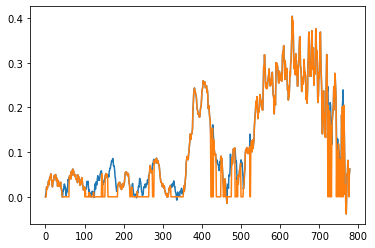

In [335]:

net_out1 = net(train_X[6].view(-1, 2, 779))

predict = net_out1[0].cpu().detach()
ground_truth = train_y[6]
noise = train_X[6][0]
            
#plt.plot(predict)
plt.plot(ground_truth) 
plt.plot(noise) 
plt.show()

In [1]:
plt.plot(predict,'green')
plt.plot(ground_truth,'blue') 
#plt.plot(noise) 
plt.show()

NameError: name 'plt' is not defined

In [337]:
outputlist = []
for i in range(len(X)):
    net_out = net(X[i].view(-1, 2, 779))

    predict = net_out[0].cpu().detach()
    outputlist.append(np.array(predict))
np.save('aut1.npy',outputlist)

outputlist = []
for i in range(len(X)):
    net_out = net(X[i].view(-1, 2, 779))

    predict = net_out[0].cpu().detach()
    outputlist.append(np.array(predict))
np.save('aut2.npy',outputlist)

In [3]:
ori = np.load('spec.npy',allow_pickle=True)
aut1 = np.load('aut1.npy',allow_pickle=True)
aut2 = np.load('aut2.npy',allow_pickle=True)

In [339]:
cancer = np.concatenate((ori, aut1, aut2),axis = 0)

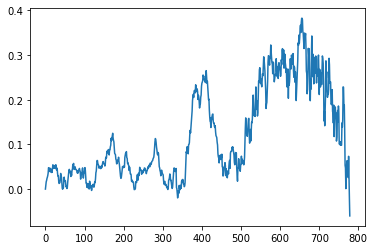

In [4]:
plt.plot(ori[0]) 

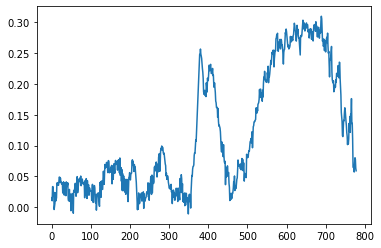

In [6]:
plt.plot(aut1[0]) 

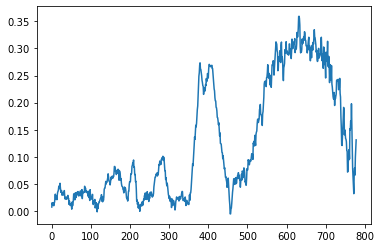

In [7]:
plt.plot(aut2[0]) 

In [8]:
spec_down = np.load('spec_down.npy',allow_pickle=True)

In [19]:
len(spec_down)

6133

In [22]:
len(spec_down[0:2])

2